In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.optim import lr_scheduler
from torchvision import models
import time
import copy

In [0]:
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [0]:
transform = transforms.Compose([transforms.Resize(224, interpolation=2),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5) 
                                                    )])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size= batch_size, shuffle=True)

0it [00:00, ?it/s]

170500096it [00:06, 26364115.19it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
dataloaders = {'train':train_loader, 'test':test_loader}
dataset_sizes = {'train':len(trainset), 'test':len(testset)}

class_names = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
def imshow(image):
    image = image / 2 +0.5
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1,2,0)))

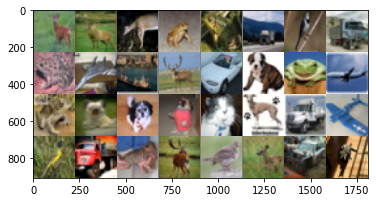

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape, labels.shape
imshow(torchvision.utils.make_grid(images))

## Pretrained Model Load

In [0]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features   # Fully Connected 층의 노드 개수(512)
model.fc = nn.Linear(num_features, 10)  # 마지막 Output 노드를 10개로 만들어줌

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.8MB/s]


In [0]:
# model.cuda()

### Loss, Optimizer

In [0]:
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.RMSprop(params=model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)

## Train, Eval

In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs=30):
    time_start = time.time()  # 시작 시간 기록(연산 시간 계산)
    
    best_model_weight = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            correct = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()  # Gradient 초기화
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(inputs).cuda()
                    preds = output.argmax(dim=1)
                    loss = loss_function(output, labels).cuda()
                    
                    # backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else:
                        preds = preds.cpu()
                
                # 결과저장
                running_loss += loss.item() * inputs.size(0)
                preds = preds.cuda()
                correct += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = correct.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.5f} Acc: {:.3f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weight = copy.deepcopy(model.state_dict())
                
        print()
        
    time_end = time.time()  # 연산 끝
    time_interval = time_end - time_start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_interval // 60,
                                                       time_interval % 60))
    print('Best Test Acc: {:.3f}'.format(best_acc))
    
    model.load_state_dict(best_model_weight)
    return model

print('========================Finished modeling')

========================Finished modeling


In [0]:
model = train_model(model, loss_function, optim, exp_lr_scheduler, 15)

Epoch 1/15
----------
train Loss: 0.78403 Acc: 0.724
test Loss: 0.79502 Acc: 0.725

Epoch 2/15
----------
train Loss: 0.52217 Acc: 0.820
test Loss: 0.53568 Acc: 0.819

Epoch 3/15
----------
train Loss: 0.37792 Acc: 0.870
test Loss: 0.46740 Acc: 0.841

Epoch 4/15
----------
train Loss: 0.27486 Acc: 0.905
test Loss: 0.66760 Acc: 0.802

Epoch 5/15
----------
train Loss: 0.19091 Acc: 0.933
test Loss: 0.44513 Acc: 0.865

Epoch 6/15
----------
train Loss: 0.14394 Acc: 0.950
test Loss: 0.47061 Acc: 0.860

Epoch 7/15
----------
test Loss: 0.49993 Acc: 0.866

Epoch 8/15
----------
train Loss: 0.08985 Acc: 0.969
test Loss: 0.57444 Acc: 0.867

Epoch 9/15
----------
train Loss: 0.02203 Acc: 0.993
test Loss: 0.50193 Acc: 0.896

Epoch 10/15
----------
train Loss: 0.00700 Acc: 0.998
test Loss: 0.50296 Acc: 0.902

Epoch 11/15
----------
train Loss: 0.00402 Acc: 0.999
test Loss: 0.53481 Acc: 0.900

Epoch 12/15
----------
train Loss: 0.00266 Acc: 0.999
test Loss: 0.55221 Acc: 0.900

Epoch 13/15
--------